In [1]:
import pandas as pd
import numpy as np
import normflows as nf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm #show loops with progress

c:\Users\Gimena\miniconda3\envs\flows\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


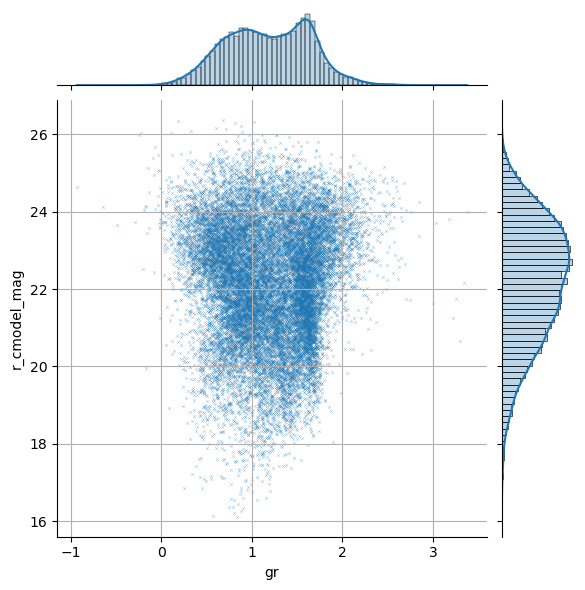

In [2]:
df = pd.read_csv('../../clean-HSC-unWISE-W01.csv')
features = ['gr', 'r_cmodel_mag']
data = df[features].values
data_tensor = torch.Tensor(data)

# grid for plots (linspace and meshgrid are the same as numpy functions)
x_points = torch.linspace(-1, 3, 200) # g- r color
y_points = torch.linspace(15, 27, 200) # r mag
(x,y) = torch.meshgrid(x_points, y_points)
# grid = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
z = torch.cat([x.unsqueeze(2), y.unsqueeze(2)], 2).view(-1, 2)

sns.jointplot(x = df[features[0]], y = df[features[1]], s=5, alpha = 0.7, marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.grid()


In [5]:
dim = len(features)
base_distribution = nf.distributions.base.DiagGaussian(dim)
# base_distribution = nf.distributions.base.GaussianMixture(n_modes= 3, dim= dim) # this does not work


layers = 7
flows = []
for i in range(layers):
    
    # NN with input layer, 2 hidden layers, and output layer. Activation: relu.
    param_map = nf.nets.MLP([1, 64, 64, dim], init_zeros=True)
    # Flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    
    # For flows that use coupling transformations, e.g. Real NVP, Neural Spline Flow, and MAF, 
    # it is recommended to use permutation between the layers of the flow
    flows.append(nf.flows.Permute(2, mode='swap'))
        
# Build the normalizing flow model
model = nf.NormalizingFlow(base_distribution, flows, data_tensor)

  0%|          | 0/1000 [00:00<?, ?it/s]

 10%|▉         | 99/1000 [00:27<04:01,  3.73it/s]

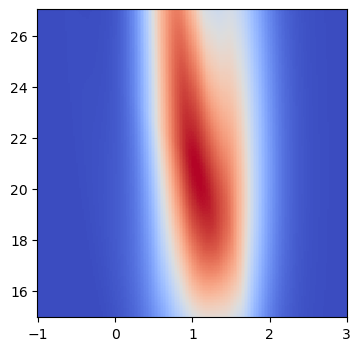

 20%|█▉        | 199/1000 [00:56<03:33,  3.75it/s]

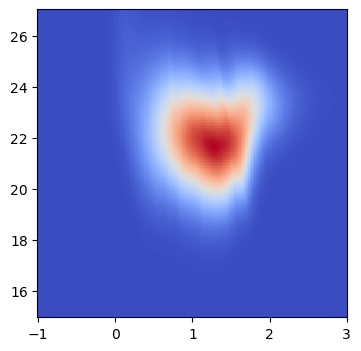

 30%|██▉       | 299/1000 [01:24<03:16,  3.56it/s]

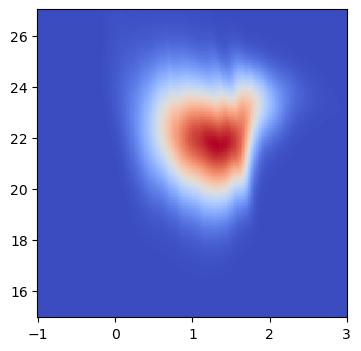

 40%|███▉      | 399/1000 [01:52<02:48,  3.57it/s]

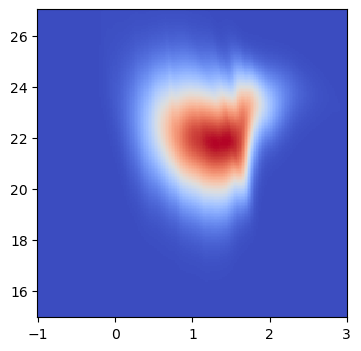

 50%|████▉     | 499/1000 [02:16<01:40,  4.97it/s]

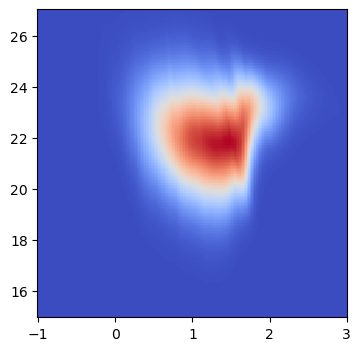

 60%|█████▉    | 599/1000 [02:38<01:37,  4.13it/s]

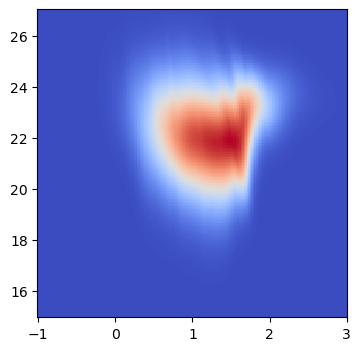

 70%|██████▉   | 699/1000 [03:01<01:02,  4.82it/s]

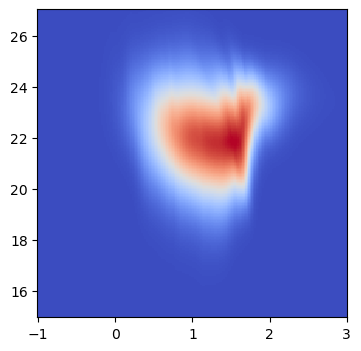

 80%|███████▉  | 799/1000 [03:23<00:51,  3.92it/s]

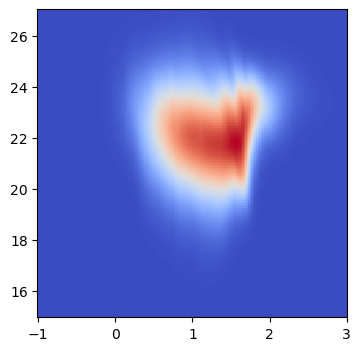

 90%|████████▉ | 899/1000 [03:50<00:24,  4.17it/s]

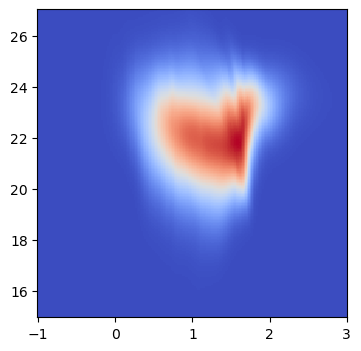

100%|█████████▉| 999/1000 [04:15<00:00,  4.17it/s]

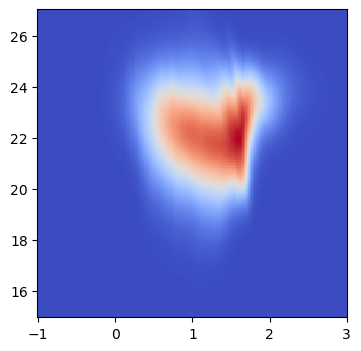

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


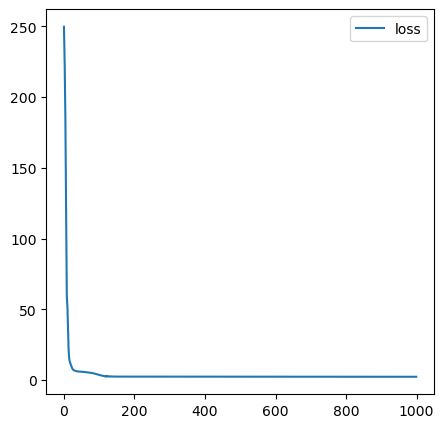

In [6]:
# Train model
max_iter = 1000
show_iter = 100


loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters()) #lr=5e-4, weight_decay=1e-5


for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
        
    # Compute loss
    loss = model.forward_kld(data_tensor)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(z)
        model.train()
        prob = torch.exp(log_prob.view(*x.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(4, 4))
        plt.pcolormesh(x, y, prob.data.numpy(), cmap='coolwarm')
        plt.show()

# Plot loss
plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

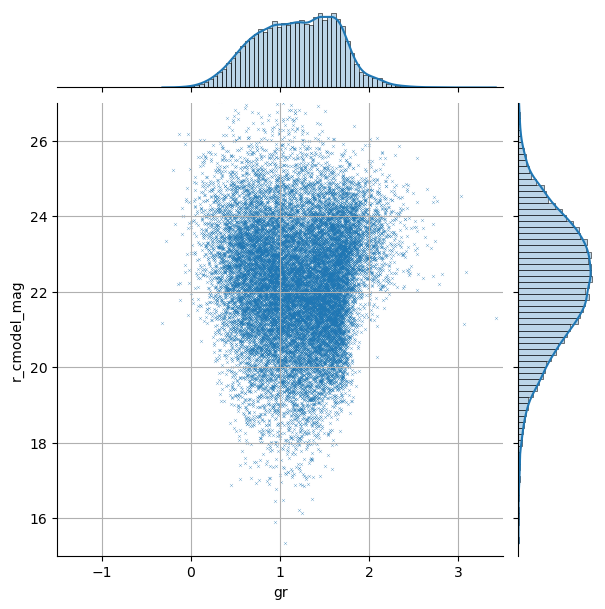

In [13]:
# plot after training
samples,_ = model.sample(num_samples=20000)
samples = samples.data.numpy()
sns.jointplot(x = samples[:, 0], y = samples[:, 1], s=5, alpha = 1., marker = 'x', marginal_kws=dict(kde = True, fill = True, alpha = 0.3))
plt.ylabel(features[1])
plt.xlabel(features[0])
plt.ylim(15,27)
plt.xlim(-1.5,3.5)
plt.grid()
plt.show()